# Load dataset
Mount drive and load dataset.

Change the path accordingly.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import tarfile

# update to your path
drive_path = '/content/drive/MyDrive/AAI3001/Datasets/'

# List of tar files
train_tar_files = ['train_fake.tar', 'train_real.tar']
val_tar_files = ['valid_fake.tar', 'valid_real.tar']

# Create a directory to extract files (if it doesn't exist)
train_extract_path = '/content/dataset/train/'
val_extract_path = '/content/dataset/val/'
os.makedirs(train_extract_path, exist_ok=True)
os.makedirs(val_extract_path, exist_ok=True)

# Extract each train tar file
for tar_file in train_tar_files:
    tar_path = os.path.join(drive_path, tar_file)
    print(f"Extracting {tar_file}...")
    with tarfile.open(tar_path) as tar:
        tar.extractall(path=train_extract_path)
    print(f"Finished extracting {tar_file}")

# Extract each val tar file
for tar_file in val_tar_files:
    tar_path = os.path.join(drive_path, tar_file)
    print(f"Extracting {tar_file}...")
    with tarfile.open(tar_path) as tar:
        tar.extractall(path=val_extract_path)
    print(f"Finished extracting {tar_file}")

Extracting train_fake.tar...
Finished extracting train_fake.tar
Extracting train_real.tar...
Finished extracting train_real.tar
Extracting valid_fake.tar...
Finished extracting valid_fake.tar
Extracting valid_real.tar...
Finished extracting valid_real.tar


In [3]:
os.listdir('/content/dataset/val/real')[0]

'valid_real_0651797.png'

In [4]:
# Import necessary libraries
import warnings
warnings.filterwarnings('ignore')

import os
import numpy as np
import pandas as pd
import soundfile as sound
import datetime
import sys, subprocess
import math
import random
import librosa
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR, ExponentialLR, CosineAnnealingLR
import torchaudio
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
from tqdm import tqdm
import logging
import time

from sklearn.metrics import confusion_matrix, classification_report, recall_score
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchaudio import functional as audioF
from torchaudio.compliance import kaldi

In [ ]:
def setup_seed(seed=2021):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True


# Custom dataset class


In [5]:
import os
from torch.utils.data import Dataset
from PIL import Image

class DeepfakeDataset(Dataset):
    def __init__(self, fake_dir, real_dir, transform=None,
                 max_fake_samples=None, max_real_samples=None,
                 random_sample=False, seed=None):
        """
        Args:
            fake_dir (str): Directory with all the fake images.
            real_dir (str): Directory with all the real images.
            transform (callable, optional): Optional transform to be applied on a sample.
            max_fake_samples (int, optional): Maximum number of fake images to load.
            max_real_samples (int, optional): Maximum number of real images to load.
            random_sample (bool, optional): If True, randomly sample images instead of taking the first N.
            seed (int, optional): Random seed for reproducibility.
        """
        self.transform = transform

        self.image_paths = []
        self.labels = []

        # Set the random seed if provided
        if seed is not None:
            random.seed(seed)

        # Load fake images and assign label 0
        fake_images = os.listdir(fake_dir)

        # Limit the number of fake images
        if max_fake_samples is not None:
            if random_sample:
                fake_images = random.sample(fake_images, max_fake_samples)
            else:
                fake_images = fake_images[:max_fake_samples]

        for img_name in fake_images:
            img_path = os.path.join(fake_dir, img_name)
            self.image_paths.append(img_path)
            self.labels.append(0)  # Label for fake images

        # Load real images and assign label 1
        real_images = os.listdir(real_dir)

        # Limit the number of real images
        if max_real_samples is not None:
            if random_sample:
                real_images = random.sample(real_images, max_real_samples)
            else:
                real_images = real_images[:max_real_samples]

        for img_name in real_images:
            img_path = os.path.join(real_dir, img_name)
            self.image_paths.append(img_path)
            self.labels.append(1)  # Label for real images

        # Shuffle the dataset to mix fake and real images
        combined = list(zip(self.image_paths, self.labels))
        random.shuffle(combined)
        self.image_paths[:], self.labels[:] = zip(*combined)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]

        # Load image
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label

# Baseline model

Custom model using VGG-18 and SVM

In [7]:
from torchvision.models import vgg19, VGG19_Weights
class DeepfakeDetectionModel(nn.Module):
    def __init__(self):
        super(DeepfakeDetectionModel, self).__init__()
        # Load the pre-trained VGG18 model
        self.feature_extractor = vgg19(weights=VGG19_Weights)

        # Remove the last classification layer to get feature embeddings
        self.feature_extractor.classifier = nn.Sequential(
            *list(self.feature_extractor.classifier.children())[:-1]
        )

        # Add a new linear layer for binary classification
        self.classifier = nn.Linear(4096, 1)  # VGG18 features are 4096-dimensional

    def forward(self, x):
        # Extract features using VGG18
        features = self.feature_extractor(x)
        # Classify using the added linear layer
        outputs = self.classifier(features)
        return outputs

# Preparing Data

In [6]:

# Define any data transformations
custom_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],  # ImageNet means
        std=[0.229, 0.224, 0.225]     # ImageNet stds
    )
])

# Create training and validation datasets
train_dataset = DeepfakeDataset(
    fake_dir='/content/dataset/train/fake',
    real_dir='/content/dataset/train/real',
    transform=custom_transform,
    #  Limit to first 5,000 fake images
    max_fake_samples=3000,
    max_real_samples=3000,
    random_sample=False,
    seed=42
)

val_dataset = DeepfakeDataset(
    fake_dir='/content/dataset/val/fake',
    real_dir='/content/dataset/val/real',
    transform=custom_transform
)

# Create data loaders
train_loader = DataLoader(
    train_dataset,
    batch_size=256,
    shuffle=True,
    num_workers=4
)

val_loader = DataLoader(
    val_dataset,
    batch_size=256,
    shuffle=False,
    num_workers=4
)

# Instantiate Model

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = DeepfakeDetectionModel()
model = model.to(device)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:02<00:00, 230MB/s]


# Define optimizer and Loss function

In [9]:
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
num_epochs = 30

In [11]:
best_val_accuracy = 0.0  # Initialize best validation accuracy
train_loss = []
val_loss = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    val_running_loss = 0.0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.float().unsqueeze(1).to(device)

        # Forward pass
        outputs = model(images)

        # Compute loss
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    epoch_loss = running_loss / len(train_loader)
    train_loss.append(epoch_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')

    # Validation step
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.float().to(device)
            outputs = model(images)
            outputs = outputs.squeeze()

            val_loss_batch = criterion(outputs, labels)
            val_running_loss += val_loss_batch.item()

            # similar to applying sigmoid and thresholding at 0.5 wkwkwk
            predicted = (outputs >= 0).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        val_loss.append(val_running_loss/ len(val_loader))
        val_accuracy = 100 * correct / total
        print(f'Validation Accuracy: {val_accuracy:.2f}%\n')

    # Save the model if validation accuracy has improved
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        torch.save(model.state_dict(), 'best_model.pth')
        print(f'Best model saved with validation accuracy: {best_val_accuracy:.2f}%')


Epoch [1/30], Loss: 0.6588
Validation Accuracy: 70.83%

Best model saved with validation accuracy: 70.83%
Epoch [2/30], Loss: 0.5384
Validation Accuracy: 75.75%

Best model saved with validation accuracy: 75.75%
Epoch [3/30], Loss: 0.4884
Validation Accuracy: 82.13%

Best model saved with validation accuracy: 82.13%
Epoch [4/30], Loss: 0.3567
Validation Accuracy: 85.87%

Best model saved with validation accuracy: 85.87%
Epoch [5/30], Loss: 0.2591
Validation Accuracy: 80.92%

Epoch [6/30], Loss: 0.1606
Validation Accuracy: 85.03%

Epoch [7/30], Loss: 0.1041
Validation Accuracy: 88.15%

Best model saved with validation accuracy: 88.15%
Epoch [8/30], Loss: 0.0921
Validation Accuracy: 83.72%

Epoch [9/30], Loss: 0.0364
Validation Accuracy: 84.08%

Epoch [10/30], Loss: 0.0381
Validation Accuracy: 84.11%

Epoch [11/30], Loss: 0.0517
Validation Accuracy: 85.38%

Epoch [12/30], Loss: 0.0149
Validation Accuracy: 84.28%

Epoch [13/30], Loss: 0.0036
Validation Accuracy: 85.35%

Epoch [14/30], Los

In [12]:
len(val_loss)

30

# Plot training loss and validation loss

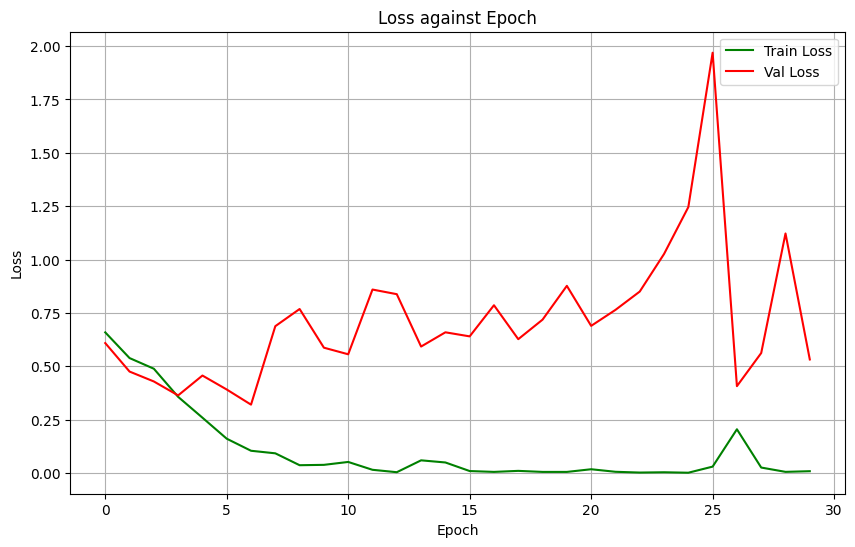

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(train_loss, '-', color='green', label='Train Loss')
plt.plot(val_loss, '-', color='red', label='Val Loss')
plt.title('Loss against Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

Test against one image

In [15]:
# Load the saved model weights
model.load_state_dict(torch.load('best_model.pth', map_location=device))
model.eval()

def predict_image(image_path):
    # Load and preprocess the image
    image = Image.open(image_path).convert('RGB')
    input_image = custom_transform(image)
    input_image = input_image.unsqueeze(0).to(device)  # Add batch dimension

    # Make prediction
    with torch.no_grad():
        output = model(input_image)
        output = output.squeeze()
        probability = torch.sigmoid(output).item()
        predicted_label = 1 if probability >= 0.5 else 0

    # Display the image and prediction
    class_names = {0: 'Fake', 1: 'Real'}
    predicted_class_name = class_names[predicted_label]

    plt.figure(figsize=(6,6))
    plt.imshow(image)
    plt.title(f'Predicted Label: {predicted_class_name}')
    plt.axis('off')
    plt.show()

    print(f'Predicted Probability of being Real: {probability:.4f}')



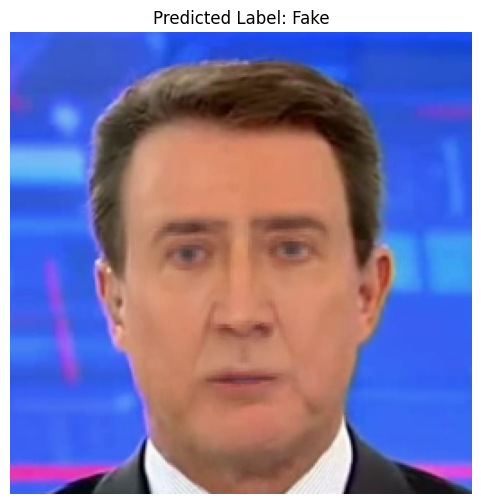

Predicted Probability of being Real: 0.0069


In [16]:
# Example usage:
image_path = '/content/dataset/val/fake/valid_fake_0101594.png'  # Replace with the path to your image
predict_image(image_path)

Interesting, it predicts the bottom image wrongly

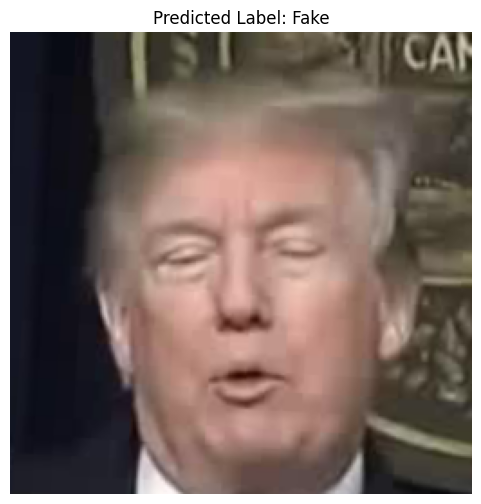

Predicted Probability of being Real: 0.0937


In [25]:
image_path = '/content/dataset/val/real/valid_real_0001299.png'  # Replace with the path to your image
predict_image(image_path)

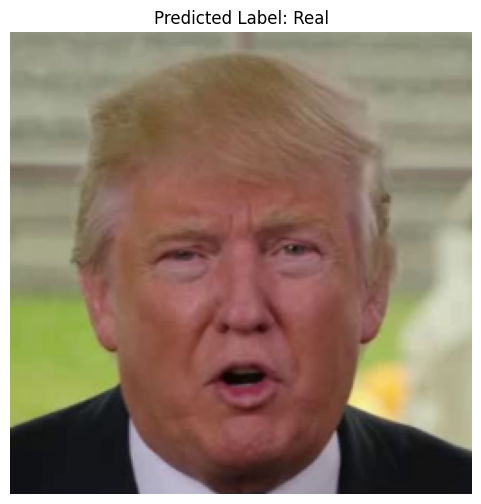

Predicted Probability of being Real: 0.9949


In [26]:
image_path = '/content/dataset/val/real/valid_real_0003389.png'  # Replace with the path to your image
predict_image(image_path)

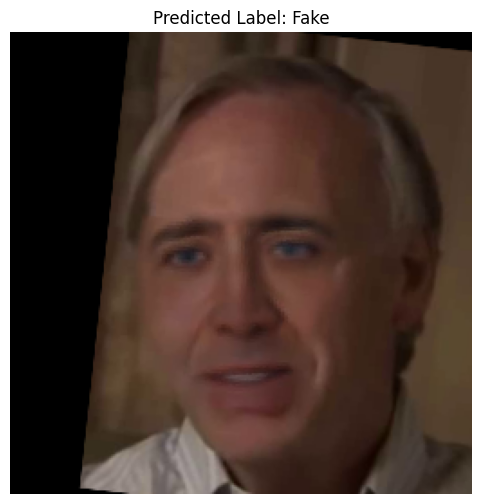

Predicted Probability of being Real: 0.0627


In [27]:
image_path = '/content/dataset/val/fake/valid_fake_0000523.png'  # Replace with the path to your image
predict_image(image_path)

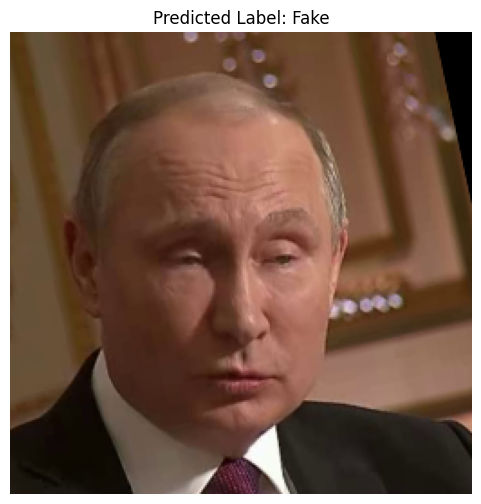

Predicted Probability of being Real: 0.0711


In [28]:
image_path = '/content/dataset/val/fake/valid_fake_0639462.png'  # Replace with the path to your image
predict_image(image_path)

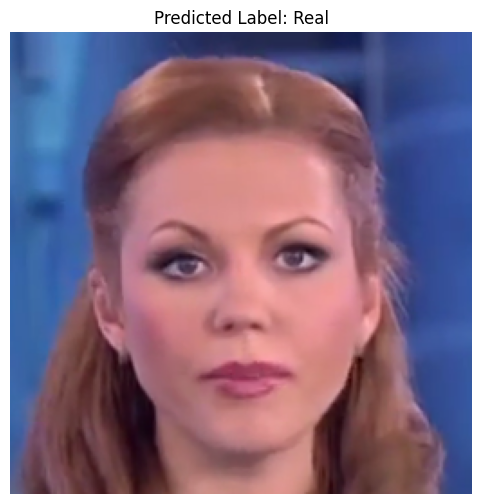

Predicted Probability of being Real: 0.6528


In [21]:
image_path = '/content/dataset/train/real/train_real_0000544.png'  # Replace with the path to your image
predict_image(image_path)

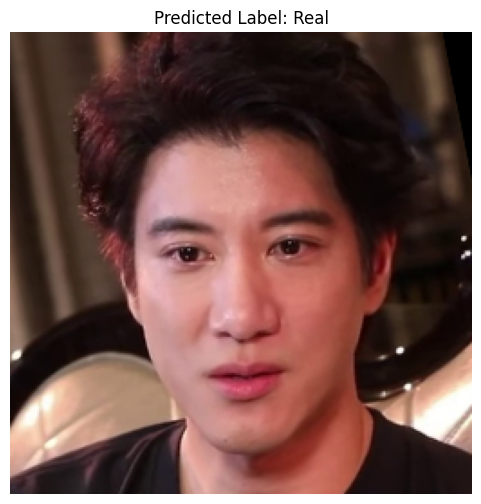

Predicted Probability of being Real: 0.9468


In [22]:
image_path = '/content/dataset/val/real/valid_real_0620540.png'  # Replace with the path to your image
predict_image(image_path)